In [1]:
# Basic Imports
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import sys
import json
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union, Type, List
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from functools import partial
from tqdm import tqdm
import pprint

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# # PyTorch for Dataloaders
import torch
import torch.nn as tnn

# Flax training loop
from flax import jax_utils
from jax.scipy.stats import beta

# JAX/Flax
import jax
from jax import jit
import jax.numpy as jnp
from jax import random as jrandom
from jax.scipy.stats import beta
import equinox as eqx
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping
import optax
import wandb
wandb_dir = os.path.join(os.path.expanduser('~'), "PFGMPP")
os.environ["WANDB_DIR"] = os.path.abspath(wandb_dir)

from data import data_functions as df

The **goal** of this notebook is to convert the [tutorial](https://github.com/Newbeeer/pfgmpp/blob/main/pfgmpp_toy.ipynb) given on the PFGM++ github from PyTorch to Equinox

The **reason** for this is that in my JAX only [notebook](https://github.com/MatthewDowicz/PFGMPP/blob/main/exampleCase.ipynb) that tried to do this with a simpler dataset (i.e. lower dimensionality) has difficulty in accurately learning the data distribution.

The difference of this notebook and the previous attempt is that I'm going to be using the `PyTorch` code for generating the datasets, so that I have the exact same data/noise distributions/etc., so that the focus can be solely on the model architecture and implementations of the training and sampling algorithms of PFGM++.

## Create a dataset of 2 Gaussians

$p_{data} = 0.5 \mathcal{N}(\mu_1, \sigma I) + 0.5 \mathcal{N}(-\mu_1, \sigma I)$

Will use the same values produced in Pytorch, so that we have a 1-to-1 comparison between our datasets for training.

In [2]:
def generate_data(seed=2, size=1000, data_dim=1000, std=0.2, mean_scale=1):
    torch.manual_seed(seed)
    
    X_0 = 1 * mean_scale + torch.randn((size, 10)) * std
    X_1 = -1 * mean_scale + torch.randn((size, 10)) * std
    
    # Embed 10D manifold to {data_dim}-dim space
    W = torch.randn((10, data_dim))
    
    X_0 = torch.matmul(X_0, W)
    X_1 = torch.matmul(X_1, W)
    
    X_0 += torch.randn_like(X_0) * 0.01
    X_1 += torch.randn_like(X_1) * 0.01
    
    X_0 = torch.clip(X_0, -100, 100)
    X_1 = torch.clip(X_1, -100, 100)
    
    X = torch.cat([X_0, X_1], dim=0)
    X = X.numpy()
    X = jnp.array(X)
    return X

(10000, 2)


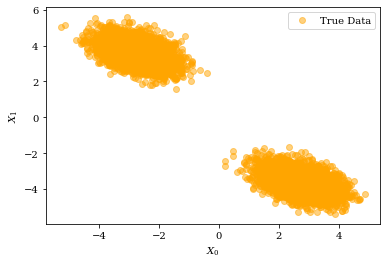

In [3]:
torch.manual_seed(2)
size = 5000
std = 0.2
mean_scale = 1

data_dim = 2

X_0 = 1 * mean_scale + torch.randn((size, 10)) * std
X_1 = -1 * mean_scale + torch.randn((size, 10)) * std

# Embed 10D manifold to {data_dim}-dim space
W = torch.randn((10, data_dim))

X_0 = torch.matmul(X_0, W)
X_1 = torch.matmul(X_1, W)

X_0 += torch.randn_like(X_0) * 0.01
X_1 += torch.randn_like(X_1) * 0.01

X_0 = torch.clip(X_0, -100, 100)
X_1 = torch.clip(X_1, -100, 100)

X = torch.cat([X_0, X_1], dim=0)
X = X.numpy()
X = jnp.array(X)
print(X.shape)
# Visualize the first two dimensions
plt.scatter(X[:, 0], X[:, 1], label='True Data', alpha=0.5, color='orange')
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.legend()
plt.show()

## Construct data loader

Need to do this because JAX/Flax don't have native dataloader functionality. This code follows closely with the PyTorch formulations.

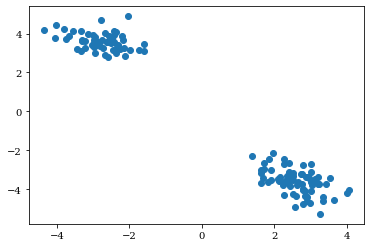

In [4]:
class JaxDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return np.array(self.X[idx])

def numpy_collate(batch):
    """
    Function to allow jnp.arrays to be used in PyTorch Dataloaders.
    """
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)
    
class NumpyLoader(torch.utils.data.DataLoader):
    """
    Custom PyTorch DataLoader for numpy/JAX arrays
    """
    def __init__(self, dataset, batch_size=1,
                 shuffle=False, sampler=None,
                 batch_sampler=None, num_workers=0,
                 pin_memory=False, drop_last=False,
                 timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
                                             batch_size=batch_size,
                                             shuffle=shuffle,
                                             sampler=sampler,
                                             batch_sampler=batch_sampler,
                                             num_workers=num_workers,
                                             collate_fn=numpy_collate,
                                             pin_memory=pin_memory,
                                             drop_last=drop_last,
                                             timeout=timeout,
                                             worker_init_fn=worker_init_fn)
    
train_dataset = JaxDataset(X=X)
train_loader = NumpyLoader(dataset=train_dataset, batch_size=128, shuffle=True)
batch = next(iter(train_loader))
# Visual check with my PyTorch notebook and these distributions are the same
plt.scatter(batch[:, 0], batch[:, 1])

## Construct NN

$$\text{P}(k, 2i) = \text{sin}\Big(\frac{k}{n^{2i/d}} \Big)$$
$$\text{P}(k, 2i+1) = \text{cos}\Big(\frac{k}{n^{2i/d}} \Big)$$

See [this](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/#:~:text=What%20Is%20Positional%20Encoding%3F,item's%20position%20in%20transformer%20models.) article about positional encoding.

Comparing the output of the `PyTorch` and `JAX/Flax` implementations to make sure they are doing the same thing.

**Testing to see if the Positional embedding functions are the same**

In [5]:
class PositionalEmbeddingJAX(eqx.Module):
    num_channels: int
    max_positions: int
    endpoint: bool 

    def __init__(self, num_channels, max_positions=10000, endpoint=False):
        self.num_channels = num_channels
        self.max_positions = max_positions
        self.endpoint = endpoint

    
    def __call__(self, x):
        freqs = jnp.arange(0, self.num_channels // 2, dtype=jnp.float32)
        freqs = freqs / (self.num_channels // 2 - (1 if self.endpoint else 0))
        freqs = (1 / self.max_positions) ** freqs
        
        x = x[:, None] * freqs[None, :] # similar to torch's ger
        x = jnp.concatenate([jnp.cos(x), jnp.sin(x)], axis=-1)
        return x

In [6]:
# Create the equivalent embedding functions in JAX/Pytorch
emb_layer_jax = PositionalEmbeddingJAX(num_channels=32)

# Sample from the noise distribution using Pytorch's RNG
# so that the noise values are the same
rnd_normal = torch.randn((batch.shape[0], 1))
t = (rnd_normal * 1.2 - 1.2).exp()
t_flat = t.flatten().log() / 4.

# Convert the noise to a numpy array for use in JAX
t_flat = t_flat.numpy()
print(t_flat.shape)
print(t_flat[0].shape)
# Calculate the embedding in JAX
x_1_jax = emb_layer_jax(t_flat)
print(x_1_jax.shape)

(128,)
()
(128, 32)


**Now checking the distributions of the model architectures**

In [7]:
class PositionalEmbeddingJAX(eqx.Module):
    num_channels: int
    max_positions: int
    endpoint: bool 

    def __init__(self, num_channels, max_positions=10000, endpoint=False):
        self.num_channels = num_channels
        self.max_positions = max_positions
        self.endpoint = endpoint

    
    def __call__(self, x):
        freqs = jnp.arange(0, self.num_channels // 2, dtype=jnp.float32)
        freqs = freqs / (self.num_channels // 2 - (1 if self.endpoint else 0))
        freqs = (1 / self.max_positions) ** freqs
        
        x = x[:, None] * freqs[None, :] # similar to torch's ger
        x = jnp.concatenate([jnp.cos(x), jnp.sin(x)], axis=-1)
        return x   

class mlp(eqx.Module):
    dim: int
    latent_dim: int
    std_data: float
    act: jax.nn.relu
    emb_layer: "PositionalEmbeddingJAX"
    fc1: eqx.nn.Linear
    fc2: eqx.nn.Linear
    fc3: eqx.nn.Linear
    fc4: eqx.nn.Linear
    fc5: eqx.nn.Linear  # Additional layer
    fc6: eqx.nn.Linear  # Additional layer
    fc_skip: eqx.nn.Linear
    fc1_skip: eqx.nn.Linear
    fc2_skip: eqx.nn.Linear  # Additional skip connection
    fc3_skip: eqx.nn.Linear  # Additional skip connection
    ln: eqx.nn.LayerNorm
    

    def __init__(self, key, dim=2, latent_dim=32, std_data=0.5):
        keys = jrandom.split(key, 10)
        
        self.dim = dim
        self.latent_dim = latent_dim
        self.std_data = std_data
        self.act = jax.nn.silu
        self.ln = eqx.nn.LayerNorm(shape=self.latent_dim, eps=1e-5, use_weight=True, use_bias=True)

        self.fc1 = eqx.nn.Linear(self.dim, self.latent_dim, key=keys[0])
        self.emb_layer = PositionalEmbeddingJAX(num_channels=self.latent_dim)
        self.fc2 = eqx.nn.Linear(self.latent_dim, self.latent_dim, key=keys[1])
        self.fc3 = eqx.nn.Linear(self.latent_dim, self.latent_dim, key=keys[2])
        self.fc4 = eqx.nn.Linear(self.latent_dim, self.latent_dim, key=keys[3])
        self.fc5 = eqx.nn.Linear(self.latent_dim, self.latent_dim, key=keys[4])
        self.fc6 = eqx.nn.Linear(self.latent_dim, self.dim, key=keys[5])

        self.fc_skip = eqx.nn.Linear(self.dim, self.latent_dim, key=keys[6])
        self.fc1_skip = eqx.nn.Linear(self.latent_dim, self.latent_dim, key=keys[7])
        self.fc2_skip = eqx.nn.Linear(self.latent_dim, self.latent_dim, key=keys[8])
        self.fc3_skip = eqx.nn.Linear(self.latent_dim, self.dim, key=keys[9])
        

    def __call__(self, x, t):
        c_out = (t * self.std_data) / (jnp.sqrt(self.std_data ** 2 + t ** 2))
        c_skip = (self.std_data ** 2) / (self.std_data ** 2 + t ** 2)

        t = jnp.log(t.flatten()) / 4.

        x_1 = self.fc1(x) + (self.emb_layer(t).flatten())
        x_1 = self.ln(x_1)
        x_2 = self.act(x_1)
        x_2 = self.ln(x_2)
        x_3 = self.act(self.fc2(x_2)) + self.fc1_skip(x_1)
        x_3 = self.ln(x_3)
        x_4 = self.act(self.fc3(x_3)) + self.fc_skip(x)
        x_4 = self.ln(x_4)
        x_5 = self.act(self.fc5(x_4)) + self.fc2_skip(x_2)
        x_5 = self.ln(x_5)
        x_6 = self.act(self.fc6(x_5)) + self.fc3_skip(x_3)

        return c_out * x_6 + c_skip * x



# class mlp(eqx.Module):
#     """
#     Common architecture for score-based generative model.
#     """
#     dim: int 
#     latent_dim: int 
#     std_data: float 
#     act: jax.nn.relu
#     emb_layer: "PositionalEmbeddingJAX"
#     fc1: eqx.nn.Linear
#     fc2: eqx.nn.Linear
#     fc3: eqx.nn.Linear
#     fc4: eqx.nn.Linear
#     fc_skip: eqx.nn.Linear
#     fc1_skip: eqx.nn.Linear
#     ln1: eqx.nn.LayerNorm
#     ln2: eqx.nn.LayerNorm
#     ln3: eqx.nn.LayerNorm

       
#     def __init__(self, key, dim=2, latent_dim=32, std_data=0.5):
#         key1, key2, key3, key4, key5, key6 = jrandom.split(key, 6)
        
#         self.dim = dim
#         self.latent_dim = latent_dim
#         self.std_data = std_data

#         self.act = jax.nn.relu

#         self.fc1 = eqx.nn.Linear(self.dim, self.latent_dim, key=key1) 
#         self.emb_layer = PositionalEmbeddingJAX(num_channels=self.latent_dim)
#         self.fc2 = eqx.nn.Linear(self.latent_dim, self.latent_dim, key=key2) 
#         self.fc3 = eqx.nn.Linear(self.latent_dim, self.latent_dim, key=key3) 
#         self.fc4 = eqx.nn.Linear(self.latent_dim, self.dim, key=key4) 
        
#         self.fc_skip = eqx.nn.Linear(self.dim, self.latent_dim, key=key5) 
#         self.fc1_skip = eqx.nn.Linear(self.latent_dim, self.latent_dim, key=key6) 

#         self.ln1 = eqx.nn.LayerNorm(shape=self.latent_dim, eps=1e-5, use_weight=True, use_bias=True)
#         self.ln2 = eqx.nn.LayerNorm(shape=self.latent_dim, eps=1e-5, use_weight=True, use_bias=True)
#         self.ln3 = eqx.nn.LayerNorm(shape=self.latent_dim, eps=1e-5, use_weight=True, use_bias=True)


#     def __call__(self, x, t):
#         # Preconditioning terms in the "EDM" model (Karras et al. 2022)
#         c_out = (t * self.std_data) / (jnp.sqrt(self.std_data ** 2 + t ** 2))
#         c_skip = (self.std_data ** 2) / (self.std_data ** 2 + t ** 2)

#         # Flatten the noise vector to become 1D because that is the shape
#         # the emb_layer is expecting
#         t = jnp.log(t.flatten()) / 4.

#         # Update positional encoding function to just work on a single example
#         x_1 = self.fc1(x) + (self.emb_layer(t).flatten())
#         x_1 = self.ln1(x_1)  # Add Layer Normalization
#         x_2 = self.act(x_1)
#         x_2 = self.ln2(x_2)  # Add Layer Normalization
#         x_3 = self.act(self.fc2(x_2)) + self.fc1_skip(x_1)
#         x_3 = self.ln3(x_3)  # Add Layer Normalization
#         x_4 = self.act(self.fc3(x_3)) + self.fc_skip(x)
#         x_4 = self.fc4(x_4)

#         return c_out * x_4 + c_skip * x

In [8]:
model = mlp(jrandom.PRNGKey(9), dim=2, latent_dim=128, std_data=1)
pred = jax.vmap(model)(batch, t.numpy())
print(model)

mlp(
  dim=2,
  latent_dim=128,
  std_data=1,
  act=<wrapped function silu>,
  emb_layer=PositionalEmbeddingJAX(
    num_channels=128,
    max_positions=10000,
    endpoint=False
  ),
  fc1=Linear(
    weight=f32[128,2],
    bias=f32[128],
    in_features=2,
    out_features=128,
    use_bias=True
  ),
  fc2=Linear(
    weight=f32[128,128],
    bias=f32[128],
    in_features=128,
    out_features=128,
    use_bias=True
  ),
  fc3=Linear(
    weight=f32[128,128],
    bias=f32[128],
    in_features=128,
    out_features=128,
    use_bias=True
  ),
  fc4=Linear(
    weight=f32[128,128],
    bias=f32[128],
    in_features=128,
    out_features=128,
    use_bias=True
  ),
  fc5=Linear(
    weight=f32[128,128],
    bias=f32[128],
    in_features=128,
    out_features=128,
    use_bias=True
  ),
  fc6=Linear(
    weight=f32[2,128],
    bias=f32[2],
    in_features=128,
    out_features=2,
    use_bias=True
  ),
  fc_skip=Linear(
    weight=f32[128,2],
    bias=f32[128],
    in_features=2,
   

# Create the loss function

In [9]:
def sample_norm(N, D, size, key):
    """
    Sample noise from perturbation kernel p_r.
    Sampling from inverse-beta distribution found in Appendix B.
    """
    R1 = jrandom.beta(a=N / 2., b=D / 2., key=key, shape=(size,))
    R2 = R1 / (1 - R1 +1e-8)
    return R2

def loss(model: mlp, x, D, key):
    key1, key2, key3= jrandom.split(key, 3)

    # Sampling from the noise distribution (Table 1 Karras et al. 2022)
    rnd_normal = jrandom.normal(key1, shape=(x.shape[0], 1))
    t = jnp.exp(rnd_normal * 1.2 - 1.2)
    # Phase alignment of the Diffusion Model -> PFGM++ (App. C)
    # Note: t = sigma in the "EDM" design choice (Karras et al. 2022)
    r = t * jnp.sqrt(D)

    # Sampling from p_r(R) by change-of-variable (App. B)
    R2 = sample_norm(model.dim, D, x.shape[0], key2)
    R3 = (r.squeeze() * jnp.sqrt(R2 + 1e-8)).reshape(len(R2), -1)

    # Sampling the uniform angle component
    unit_gaussian = jrandom.normal(key3, shape=(x.shape[0], model.dim))
    # print(f"unit_gaussian.shape = {unit_gaussian.shape}")
    unit_gaussian = unit_gaussian / jnp.linalg.norm(unit_gaussian, ord=2, axis=1, keepdims=1)
    x_hat = x + (unit_gaussian * R3)

    # Preconditions (Table 1 & Sect. 5 of Karras et al. 2022)
    c_in = 1 / jnp.sqrt(model.std_data**2 + t**2)
    c_out = t * model.std_data / jnp.sqrt(model.std_data**2 + t**2)
    c_skip = model.std_data**2 / (model.std_data**2 + t**2)
    
    # f_theta in Karras et al. 2022
    D_x = jax.vmap(model)(x_hat*c_in, t)

    # lambda(theta) in Karras et al. 2022
    # using the loss weighting of "EDM"
    weight = (t**2 + model.std_data**2) / (t * model.std_data) ** 2

    # Calculate weighted loss
    loss = jnp.sum(weight * ((D_x - x) ** 2), axis=1).mean()
    return loss

# Example loss
loss_value = loss(model, batch, D=2, key=jrandom.PRNGKey(27))
print(f"loss_value.shape = {loss_value.shape}") # Scalar loss
print(f"loss_value = {loss_value}")
# Example inference
print(batch.shape)
print(t.numpy().shape)
output = jax.vmap(model)(batch, t.numpy())
print(output.shape) # Batch of predictions

loss_value.shape = ()
loss_value = 15.373900413513184
(128, 2)
(128, 1)
(128, 2)


# Filtering

In [10]:
value, grads = eqx.filter_value_and_grad(loss)(model, batch, D=1e5, key=jrandom.PRNGKey(27))
print(value)

7.0706987


# Training

In [11]:
LEARNING_RATE = 1e-3

In [12]:
optim = optax.adamw(LEARNING_RATE)

In [13]:
def get_base_dir() -> str:
    """
    Determine the base directory of the project. This function checks if the
    code is running within a Jupyter notebook or as a standalone Python script.
    
    Returns:
        str: The absolute path of the base directory.
    """
    # Check if running in a Jupyter notebook
    if 'ipykernel' in sys.modules:
        # Assuming notebooks are in the 'notebooks' folder, move one folder up to get to the base directory.
        return os.path.abspath(os.path.join(os.getcwd(), ".."))
    else:
        # Get the directory of the current script and move one folder up to the base directory.
        return os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))

def save(filename: str, hyperparams: Dict[str, Any], model: Any) -> None:
    """
    Save the model along with hyperparameters to a specified file.

    Args:
        filename (str): The name of the file to save the model to.
        hyperparams (Dict[str, Any]): Hyperparameters to save along with the model.
        model (Any): The model to save.

    Returns:
        None
    """
    # Fetch the base directory
    base_dir = get_base_dir()
    
    # Determine the full path where models should be saved
    save_directory = os.path.join(base_dir, 'saved_models')
    
    # Ensure the directory exists; if not, create it.
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    # Construct the full path to save the model
    full_path = os.path.join(save_directory, filename)

    # Save the model and hyperparameters
    with open(full_path, "wb") as f:
        hyperparam_str = json.dumps(hyperparams)
        f.write((hyperparam_str + "\n").encode())
        eqx.tree_serialise_leaves(f, model)

In [14]:
def train(model: mlp,
          train_loader: torch.utils.data.DataLoader,
          optim: optax.GradientTransformation,
          D: int,
          epochs: int,
          key: jax.random.PRNGKey) -> mlp:
    """
    Train a mlp model using the provided data loaders and optimizers.

    Args:
        model (mlp): The model to train.
        trainloader (DataLoader): DataLoader for the training set.
        optim (optax.GradientTransformation): The optimization algorithm.
        epochs (int): The number of training epochs.

    Returns:
        mlp: The trained model.
    """

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    # Initialize wandb 
    wandb.init(project="Equinox_PFGM++", dir='../')

    # Initialize the variable to track the best train loss
    best_train_loss = float('inf')
    
    @eqx.filter_jit
    def make_step(
        model: mlp,
        opt_state: PyTree,
        x: Float[Array, "batch 1000"],
        D: int,
        key: jax.random.PRNGKey
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, D, key)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    # Main training loop
    for epoch in tqdm(range(epochs)):  # Loop over each epoch
        epoch_train_loss = 0.0
        batch_count = 0
        for step, x in enumerate(train_loader):  # Loop over all mini-batches
            x = x
            model, opt_state, train_loss = make_step(model, opt_state, x, D, key)
            
            epoch_train_loss += train_loss.item()
            batch_count += 1

        # Average loss over all mini-batches
        epoch_train_loss /= batch_count  

        # Log the training and test loss using wandb
        wandb.log({"train_loss": epoch_train_loss})

        # Check if this test_loss is the best one we've seen so far
        if epoch_train_loss < best_train_loss:
            # Update the best test loss   
            best_train_loss = epoch_train_loss 
            # Save the model at the end of each epoch
            save(
                filename=f"{wandb.run.name}.eqx", 
                hyperparams={'dim': model.dim, 'latent_dim': model.latent_dim, 'std_data': model.std_data},
                model=model
            )
        
        print(
            f"{epoch=}, train_loss={epoch_train_loss}"
        )
    return model

In [15]:
model = train(model, train_loader, optim, D=1e5, epochs=20, key=jax.random.PRNGKey(0))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mdowicz. Use `wandb login --relogin` to force relogin


  5%|▌         | 1/20 [00:14<04:31, 14.29s/it]

epoch=0, train_loss=3.221169719213172


 10%|█         | 2/20 [00:24<03:37, 12.06s/it]

epoch=1, train_loss=2.422568315192114


 15%|█▌        | 3/20 [00:35<03:12, 11.32s/it]

epoch=2, train_loss=2.106996199752711


 20%|██        | 4/20 [00:45<02:54, 10.89s/it]

epoch=3, train_loss=1.7903640828555143


 25%|██▌       | 5/20 [00:55<02:39, 10.65s/it]

epoch=4, train_loss=1.6411920619916311


 30%|███       | 6/20 [01:05<02:27, 10.50s/it]

epoch=5, train_loss=1.5779448415659652


 35%|███▌      | 7/20 [01:16<02:15, 10.40s/it]

epoch=6, train_loss=1.5709291802176946


 40%|████      | 8/20 [01:26<02:04, 10.35s/it]

epoch=7, train_loss=1.502883432786676


 45%|████▌     | 9/20 [01:36<01:53, 10.29s/it]

epoch=8, train_loss=1.533045993575567


 50%|█████     | 10/20 [01:46<01:42, 10.26s/it]

epoch=9, train_loss=1.4804356641407255


 55%|█████▌    | 11/20 [01:56<01:32, 10.25s/it]

epoch=10, train_loss=1.4900705995438974


 60%|██████    | 12/20 [02:07<01:21, 10.24s/it]

epoch=11, train_loss=1.4601792051822324


 65%|██████▌   | 13/20 [02:17<01:11, 10.26s/it]

epoch=12, train_loss=1.4960654294943507


 70%|███████   | 14/20 [02:27<01:01, 10.30s/it]

epoch=13, train_loss=1.465775507914869


 75%|███████▌  | 15/20 [02:38<00:51, 10.35s/it]

epoch=14, train_loss=1.4754032349284691


 80%|████████  | 16/20 [02:48<00:41, 10.36s/it]

epoch=15, train_loss=1.4604468194744256


 85%|████████▌ | 17/20 [02:59<00:31, 10.38s/it]

epoch=16, train_loss=1.4499014751820625


 90%|█████████ | 18/20 [03:09<00:20, 10.41s/it]

epoch=17, train_loss=1.4593064875542363


 95%|█████████▌| 19/20 [03:19<00:10, 10.41s/it]

epoch=18, train_loss=1.441015510619441


100%|██████████| 20/20 [03:30<00:00, 10.52s/it]

epoch=19, train_loss=1.441108398799655


# Inference

In [16]:
max_t = 80
min_t = 0.1
num_steps = 50
sample_size = 2000
S_churn = 0 # S_churn = 0 is the deterministic sampler from Karras et al. 2022
S_min = 0.1
S_max = 5
S_noise = 1
D = 1e5
N = model.dim
key = jrandom.PRNGKey(32)
key1, key2, key3, key4, key5 = jrandom.split(key, 5) 

rho = 7
latents = jrandom.normal(key1, shape=(sample_size, N))

# Time step discretization (t = sigma ~ r)
# Eqn. giiven in D.3 of PFGM++ paper
step_indices = jnp.arange(num_steps)
t_steps = (max_t**(1/rho) + step_indices / (num_steps - 1) * (min_t**(1/rho) - max_t**(1/rho))) ** rho
# Convert t_steps to arr & add zero to end i.e. t_N=0
t_steps = jnp.concatenate([t_steps, jnp.zeros_like(t_steps[:1])]) 
print(t_steps.shape)


##########################
### Main Sampling Loop ###
##########################

std_data = model.std_data # model.std_data = 1, it's 0.5 in Karras et al. 2022 Table 1

r_max = t_steps[0] * jnp.sqrt(D) # r = sigma \sqrt{D} formula

# Sample noise from perturbatioon kernel p_r(R) = sampling from inverse-beta
# by change-of-variable (App. B of PFGM++)
R2 = sample_norm(N, D, sample_size, key2)
R3 = (r_max.squeeze() * jnp.sqrt(R2 + 1e-8)).reshape(len(R2), -1)

# Uniformly sample the angle component
gaussian = jrandom.normal(key3, shape=(sample_size, N))
unit_gaussian = gaussian / jnp.linalg.norm(gaussian, ord=2, axis=1, keepdims=True)

# Construct the perturbation (similar to Algo. 2 in Karras et al. 2022)
x_next = unit_gaussian * R3
x_orig = x_next

# Loop over consecutive elements in 't_steps', while keeping
# track of the index of each pair
for i, (t_cur, t_next) in tqdm(enumerate(zip(t_steps[:-1], t_steps[1:]))):
    x_cur = x_next

    # Increase noise temporarily
    gamma = S_churn / num_steps if S_min <= t_cur <= S_max else 0
    t_hat = t_cur + gamma * t_cur
    x_hat = x_cur + jnp.sqrt(t_hat**2 - t_cur**2) * S_noise * jrandom.normal(key4, shape=x_cur.shape)

    # Euler step & preconditions (Table 1 in Karras et al. 2022)
    c_in = 1 / jnp.sqrt(std_data**2 + t_hat**2)
    # print(f"(x_hat*c_in).shape = {(x_hat*c_in).shape}")
    # print(f"t_hat.shape = {t_hat.shape}")
    # print(f"t_hat = {t_hat}")

    t_hat_broadcasted = jnp.broadcast_to(t_hat, (x_hat * c_in).shape[0])
    # print(f"t_hat_broadcasted.shape = {t_hat_broadcasted.shape}")

    denoised = jax.vmap(model)(x_hat * c_in, t_hat_broadcasted)
    d_cur = (x_hat - denoised) / t_hat
    x_next = x_hat + (t_next - t_hat) * d_cur

    # Apply 2nd order correction:
    if i < num_steps - 1:
        # Preconditions 
        c_in = 1 / jnp.sqrt(std_data**2 + t_next**2)
        
        t_next_broadcasted = jnp.broadcast_to(t_next, (x_next * c_in).shape[0])
        # print(f"t_hat_broadcasted.shape = {t_hat_broadcasted.shape}")
        
        denoised = jax.vmap(model)(x_next * c_in, t_next_broadcasted)
        d_prime = (x_next - denoised) / t_next
        x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)

(51,)


50it [00:05,  9.47it/s]


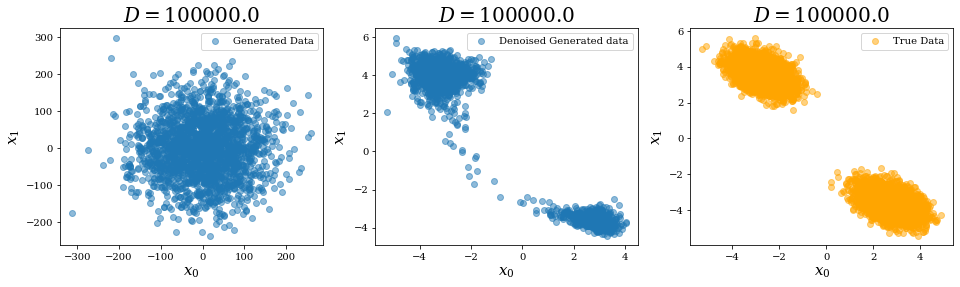

In [17]:
# size = 2000 # N
std = 0.2
mean_scale = 1

var_data = std**2 + mean_scale**2 
std_data = jnp.sqrt(var_data)

generated_X = x_next * std_data

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 4))

ax0.scatter(x_orig[:, 0], x_orig[:, 1], label='Generated Data', alpha=0.5)
ax0.set_title(f'$D={D}$', fontsize=20)
ax0.set_xlabel('$x_0$', fontsize=15)
ax0.set_ylabel('$x_1$', fontsize=15)
ax0.legend()

ax1.scatter(generated_X[:, 0], generated_X[:, 1], label='Denoised Generated data', alpha=0.5)
ax1.set_title(f'$D={D}$', fontsize=20)
ax1.set_xlabel('$x_0$', fontsize=15)
ax1.set_ylabel('$x_1$', fontsize=15)
ax1.legend()

ax2.scatter(X[:, 0], X[:, 1], label='True Data', alpha=0.5, color='orange')
ax2.set_title(f'$D={D}$', fontsize=20)
ax2.set_xlabel('$x_0$', fontsize=15)
ax2.set_ylabel('$x_1$', fontsize=15)
ax2.legend()